In [1]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import contextily as ctx
import cpi
import pandas as pd
from datetime import date
from shapely.geometry import Point

In [2]:
cpi.update()
%matplotlib notebook

OperationalError: near ")": syntax error

# Analysis 1: Kalihiwai vicinity prop values

In [3]:
huliaina = gpd.read_file("./huliaina (2).zip", crs="EPSG:26904").to_crs("EPSG:4326")
corelogic = gpd.read_file("./corelogic_with_tmk.csv")

In [4]:
# grab the properties under 5 acres
maxacres = 5
small = huliaina[huliaina["TAXACRES"] < maxacres]

# set up years of interest
years = sorted([
    '2016', '2015', '2014', '2013', '2012', '2011', '2010', '2005', '1990',
    '1985', '1980', '1975', '1970', '1965',
])

# adjust for inflation
inflated = small.copy(deep=True)[years + ["geometry"]]
inflation_base = date(2018, 1, 1)
for year in years:
    inflated[year] = inflated[year].apply(lambda x: cpi.inflate(x, date(int(year), 1, 1), to=inflation_base))

# calculate the mean property value for each year (for properties with data)
mean_value = []
for year in years:
    mean_value.append(inflated[year][inflated[year] != 0].mean())

In [5]:
corelogic["geometry"] = [Point(float(lon), float(lat)) for lon, lat in zip(corelogic.PARCEL_LON, corelogic.PARCEL_LAT)]
corelogic["MARKET_TOTAL_VALUE"][corelogic["MARKET_TOTAL_VALUE"] == ""] = "nan"
corelogic["MARKET_TOTAL_VALUE"] = corelogic["MARKET_TOTAL_VALUE"].astype(float)

/var/folders/dm/y4ghq6t940n1__g5lvs8g6tr0000gn/T/ipykernel_25144/80693696.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corelogic["MARKET_TOTAL_VALUE"][corelogic["MARKET_TOTAL_VALUE"] == ""] = "nan"


In [6]:
matching_corelogic = pd.concat([corelogic[corelogic.within(parcel)] for parcel in inflated.geometry])

In [7]:
corelogic_2019_mean = cpi.inflate(matching_corelogic.MARKET_TOTAL_VALUE.mean(), date(2019, 1, 1), to=inflation_base)

<IPython.core.display.Javascript object>


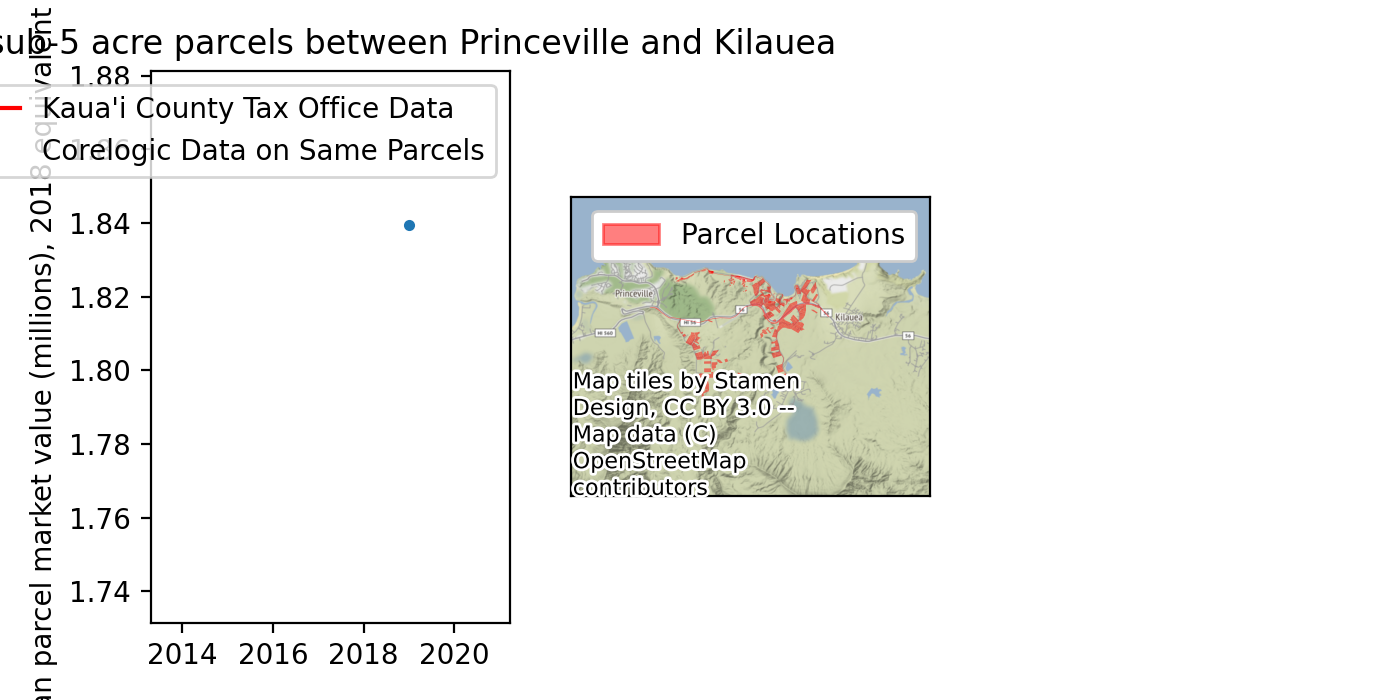

In [10]:
# this plots the huliaina parcels within a basemap
%matplotlib notebook
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(7, 3.5))
inflated.plot(ax=ax1, color="red", alpha=.5)
ax1.set_xlim([-159.5, -159.38])
ax1.set_ylim([22.15, 22.25])
ctx.add_basemap(ax1, crs = huliaina.crs, url = ctx.providers.OpenTopoMap.url)
#points = matching_corelogic.plot(ax=ax1, color="tab:blue", markersize=5, alpha=.5)
LegendElement = [
    mpatches.Patch(color='red', label='Parcel Locations', alpha=.5),
    #Line2D([0], [0], marker='o', color='w', label='Matching Corelogic Parcels',
    #                    markerfacecolor='tab:blue', markersize=5)
]
ax1.legend(handles = LegendElement, loc='upper right', framealpha=1)
ax1.set_xticks([])
ax1.set_yticks([])

x = [int(y) for y in years]
ax2.plot(x, np.array(mean_value)/1e6, "red", label="Kaua'i County Tax Office Data")
ax2.plot(2019, corelogic_2019_mean/1e6, '.', label="Corelogic Data on Same Parcels")
ax2.set_ylabel(f"mean parcel market value (millions), {inflation_base.year} equivalent USD")
ax2.set_title(f"Values of sub-{maxacres} acre parcels between Princeville and Kilauea")
ax2.legend()
plt.tight_layout()
plt.savefig("/Users/dklink/Desktop/property_values.png", dpi=200)

# Analysis 2: Map of NS Mailing Zip Codes

In [ ]:
import pgeocode
nomi = pgeocode.Nominatim('us')

In [ ]:
NS_zips = [96722, 96754]
owners = pd.read_csv("./KauaiCountyHI-20211202-PropertyOwnerMaster.csv")
owners = owners[owners.Zip.isin(NS_zips)]

In [ ]:
mainland_owners = owners[owners.OwnerState != "HI"]
locations = nomi.query_postal_code(owners["OwnerZip"].values).dropna(subset=["latitude", "longitude"])
mainland_locations = nomi.query_postal_code(mainland_owners["OwnerZip"].values).dropna(subset=["latitude", "longitude"])

In [ ]:
US = gpd.read_file("./cb_2018_us_state_500k.zip")

In [ ]:
counts = mainland_locations.groupby("postal_code").count()
sizes = counts.loc[mainland_locations.postal_code]["longitude"].values / 10
fig, ax = plt.subplots(figsize=(7, 7))
US.plot(ax=ax)
ax.set_xlim([-129, -65])
ax.set_ylim([23, 51])
ax.scatter(mainland_locations.longitude, mainland_locations.latitude, s=sizes, color="r")
ax.set_title(f"{len(mainland_locations)/len(locations): .0%} of North Shore Kaua'i mailing addresses are in the mainland")
ax.set_xticks([])
ax.set_yticks([])
plt.savefig("/Users/dklink/Desktop/continental_US_mailing_addresses.png", dpi=200)

In [ ]:
ca_locations = mainland_locations[mainland_locations["state_code"] == "CA"]
counts = ca_locations.groupby("postal_code").count()
sizes = counts.loc[ca_locations.postal_code]["longitude"].values / 2
fig, ax = plt.subplots(figsize=(7, 7))
US.plot(ax=ax)
ax.set_xlim([-125, -114])
ax.set_ylim([31, 43])
ax.scatter(ca_locations.longitude, ca_locations.latitude, s=sizes, color="r")
ax.set_title(f"{len(ca_locations)/len(mainland_locations): .0%} of mainland addresses are in California")
ax.set_xticks([])
ax.set_yticks([])
plt.savefig("/Users/dklink/Desktop/CA_mailing_addresses.png", dpi=200)

In [ ]:
bay_lon = [-122.8, -121.8]
bay_lat = [37.2, 38.2]
bay_locations = locations[(bay_lon[0] < locations.longitude) &
                          (locations.longitude < bay_lon[1]) & 
                          (bay_lat[0] < locations.latitude) &
                          (locations.latitude < bay_lat[1])]
counts = ca_locations.groupby("postal_code").count()
sizes = counts.loc[ca_locations.postal_code]["longitude"].values / 2
fig, ax = plt.subplots(figsize=(7, 7))
US.plot(ax=ax)
ax.set_xlim(bay_lon)
ax.set_ylim(bay_lat)
ax.scatter(ca_locations.longitude, ca_locations.latitude, s=sizes, color="r")
ax.set_title(f"{len(bay_locations)/len(ca_locations): .0%} of California Addresses are in the Bay Area")
ax.set_xticks([])
ax.set_yticks([])
plt.savefig("/Users/dklink/Desktop/bay_mailing_addresses.png", dpi=200)